# Artist classification using BERT
This notebook uses a transformer-based model BERT on the task of artist classification.

The notebook first uses a pre-trained base cased BERT model to get lyrics embeddings, which are later used with k nearest neighbors (kNN) to classify artists.

It continues with fine-tuning the base model for text classification, as it's the usual approach when fine-tuning BERT on downstream tasks.

And finally it uses the fine-tuned model to again get lyrics embeddings and use kNN to classify artists. The point is to see how effective fine-tuning is for specific embedding tasks.

------



## Pre-trained BERT embeddings with kNN

Load the dataset from the ``data`` folder and get a name of all the artists present in the set for label mapping.

In [ ]:
from datasets import load_dataset, ClassLabel

dataset_folder = '../data/'

dataset = load_dataset('csv',
                     data_files={
                        'train': dataset_folder + 'songs_train.txt',
                        'test': dataset_folder + 'songs_test.txt',
                        'dev': dataset_folder + 'songs_dev.txt',
                     },
                     column_names=['artist', 'title', 'lyrics'],
                     sep='\t')


artists_set = set(dataset['artist'])

artists = ClassLabel(names=list(artists_set))

A function used to preprocess the dataset before feeding it to the model

In [ ]:
def add_sentence_special_token(example):
    example['lyrics'] = example['lyrics'].replace(' NEWLINE ', ' [SEP] ')

    return example

Using the classic pre-trained BERT model and Huggingface's ``FeatureExtractionPipeline`` to pass in the lyrics and getting the models embeddings.

In [ ]:
from transformers import AutoTokenizer, AutoModel, FeatureExtractionPipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.notebook import tqdm

model_name = "bert-base-uncased"

model =  AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

feature_extract_pipeline = FeatureExtractionPipeline(model=model, tokenizer=tokenizer, framework='pt',  device=1)

def get_embeddings(dataset):
    dataset = dataset.map(add_sentence_special_token)

    embeddings = []
    labels = artists.str2int(dataset['artist'])

    pipe = feature_extract_pipeline(KeyDataset(dataset, 'lyrics'), batch_size=32, truncation=True)

    for embedding in tqdm(pipe, total=len(dataset)):
        clr_embedding = embedding[0][0]

        embeddings.append(clr_embedding)

    return embeddings, labels

Can specify the number of training and test examples to get their BERT embedding representation

In [ ]:
train_num_examples = 10000
test_num_examples = 100

### Pre-trained with kNN (train=10k, test=100)
Gets a subset of the dataset and converts it to pre-trained BERT embeddings

In [13]:
train_examples = dataset['train'].select(range(train_num_examples))
test_examples = dataset['test'].select(range(test_num_examples))

test_embeddings, test_lables = get_embeddings(test_examples)
train_embeddings, train_labels = get_embeddings(train_examples)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fits kNN with the training embeddings. ``weights=distance`` will consider closer neighbors more important.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(weights="distance")
neigh.fit(train_embeddings, train_labels)

KNeighborsClassifier(weights='distance')

Load the evaluation metric. Throughout all the experiments the notebook will be using ``accuracy`` as the metric

In [16]:
import evaluate

acc_metric = evaluate.load("accuracy")

Matplotlib is building the font cache; this may take a moment.


Here the notebook runs the predictions on different hyperparameters to see how it performs on different settings - which are then plotted

n: 1 acc: 0.03
n: 2 acc: 0.03
n: 3 acc: 0.03
n: 4 acc: 0.04
n: 5 acc: 0.05
n: 6 acc: 0.05
n: 7 acc: 0.05
n: 8 acc: 0.04
n: 9 acc: 0.04
n: 10 acc: 0.05
n: 11 acc: 0.06
n: 12 acc: 0.06
n: 13 acc: 0.06
n: 14 acc: 0.07
n: 15 acc: 0.07
n: 16 acc: 0.07
n: 17 acc: 0.05
n: 18 acc: 0.06
n: 19 acc: 0.06
n: 20 acc: 0.06
n: 21 acc: 0.06
n: 22 acc: 0.06
n: 23 acc: 0.06
n: 24 acc: 0.06
n: 25 acc: 0.06
n: 26 acc: 0.05
n: 27 acc: 0.05
n: 28 acc: 0.05
n: 29 acc: 0.05

Training examples: 10000
Test examples: 100


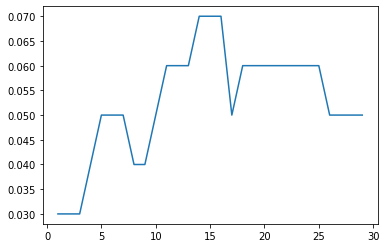

In [17]:
import matplotlib.pyplot as plt

n_neighbours = []
scores = []

# Test out the results on different n (number of neighbors to consider)
for n in range(1,30):
    neigh.set_params(n_neighbors=n)
    predictions = neigh.predict(test_embeddings)

    metric = acc_metric.compute(predictions=predictions, references=test_labels)
    score = metric['accuracy']

    print('n:', n, 'acc:', score)

    n_neighbours.append(n)
    scores.append(score)


print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))

plt.plot(n_neighbours, scores)
plt.show()

### Pre-trained with kNN (train=20k, test=100)
Gets a subset of the dataset and converts it to pre-trained BERT embeddings

In [ ]:
train_num_examples = 20000
test_num_examples = 100

In [ ]:
train_examples = dataset['train'].select(range(train_num_examples))
test_examples = dataset['test'].select(range(test_num_examples))

test_embeddings, test_lables = get_embeddings(test_examples)
train_embeddings, train_labels = get_embeddings(train_examples)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fits kNN with the training embeddings. ``weights=distance`` will consider closer neighbors more important.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(weights="distance")
neigh.fit(train_embeddings, train_labels)

KNeighborsClassifier(weights='distance')

Here the notebook runs the predictions on different hyperparameters to see how it performs on different settings - which are then plotted

n: 1 acc: 0.04
n: 2 acc: 0.04
n: 3 acc: 0.04
n: 4 acc: 0.05
n: 5 acc: 0.05
n: 6 acc: 0.05
n: 7 acc: 0.04
n: 8 acc: 0.04
n: 9 acc: 0.05
n: 10 acc: 0.05
n: 11 acc: 0.06
n: 12 acc: 0.08
n: 13 acc: 0.09
n: 14 acc: 0.08
n: 15 acc: 0.09
n: 16 acc: 0.1
n: 17 acc: 0.1
n: 18 acc: 0.1
n: 19 acc: 0.08
n: 20 acc: 0.08
n: 21 acc: 0.08
n: 22 acc: 0.08
n: 23 acc: 0.08
n: 24 acc: 0.08
n: 25 acc: 0.08
n: 26 acc: 0.08
n: 27 acc: 0.08
n: 28 acc: 0.08
n: 29 acc: 0.08

Training examples: 20000
Test examples: 100


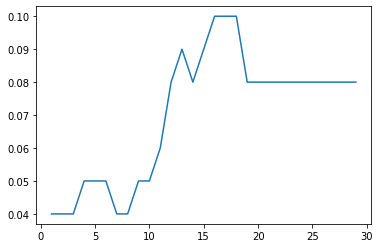

In [21]:
import matplotlib.pyplot as plt

n_neighbours = []
scores = []

# Test out the results on different n (number of neighbors to consider)
for n in range(1,30):
    neigh.set_params(n_neighbors=n)
    predictions = neigh.predict(test_embeddings)

    metric = acc_metric.compute(predictions=predictions, references=test_labels)
    score = metric['accuracy']

    print('n:', n, 'acc:', score)

    n_neighbours.append(n)
    scores.append(score)


print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))

plt.plot(n_neighbours, scores)
plt.show()

## Fine-tune BERT on artist classification

The notebook is now going to fine-tune the BERT model on SequenceClassification task.

Since it's loading the model for sequence classification, we need to pass it the number of labels it needs to learn to predict and specify the ``problem_type="single_label_classification"`` so that it knows to make the model return only one classification.

In [3]:
from transformers import AutoModelForSequenceClassification 

model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=artists.num_classes,
                                                           problem_type="single_label_classification"
                                                          )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Tokenize the lyrics of the dataset and turn labels to numbers

In [26]:
def transform(batch):
    batch['labels'] = artists.str2int(batch['artist'])
    return tokenizer(batch["lyrics"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(transform, batched=True).remove_columns(['artist', 'title', 'lyrics'])
tokenized_datasets

Parameter 'function'=<function transform at 0x7fd533c89310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 46120
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5765
    })
    dev: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5765
    })
})

With ``accuracy`` we'll also monitor the ``F1`` metric of models performance

In [27]:
import evaluate
import numpy as np

def compute_metrics(eval_preds):
    f1_metric = evaluate.load("f1")
    acc_metric = evaluate.load("accuracy")
    
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    metric = acc_metric.compute(predictions=predictions, references=labels)
    metric.update(f1_metric.compute(predictions=predictions, references=labels, average="micro"))

    return metric

Prepare the training arguments for models training.

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="../models",
    evaluation_strategy="steps",
    gradient_checkpointing=True,
    eval_steps=150,
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    num_train_epochs=3,
    weight_decay=0.01,               # strength of weight decay
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['dev'],
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [15]:
trainer.train()

***** Running training *****
  Num examples = 46120
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 14415


Step,Training Loss,Validation Loss,Accuracy,F1
150,No log,6.220192,0.003816,0.003816
300,No log,6.197334,0.004510,0.004510
450,No log,6.160745,0.005898,0.005898
600,6.182000,6.063807,0.008500,0.008500
750,6.182000,6.020972,0.011275,0.011275
900,6.182000,5.945712,0.010755,0.010755
1050,5.993800,5.896107,0.014744,0.014744
1200,5.993800,5.794146,0.018040,0.018040
1350,5.993800,5.775152,0.018040,0.018040
1500,5.822300,5.754690,0.016305,0.016305


***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
Saving model checkpoint to /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-500
Configuration saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-500/config.json
Model weights saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
Saving model checkpoint to /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-1000
Configuration saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-1000/config.json
Model weights saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoin

***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
Saving model checkpoint to /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8000
Configuration saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8000/config.json
Model weights saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
Saving model checkpoint to /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8500
Configuration saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8500/config.json
Model weights saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num exampl

TrainOutput(global_step=14415, training_loss=4.554168419601435, metrics={'train_runtime': 18956.7237, 'train_samples_per_second': 12.165, 'train_steps_per_second': 0.76, 'total_flos': 6.10226018469888e+16, 'train_loss': 4.554168419601435, 'epoch': 5.0})

In [17]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64


{'eval_loss': 4.75047492980957,
 'eval_accuracy': 0.10893321769297484,
 'eval_f1': 0.10893321769297484,
 'eval_runtime': 70.3119,
 'eval_samples_per_second': 81.992,
 'eval_steps_per_second': 1.294,
 'epoch': 5.0}

## Fine-tuned BERT embeddings with kNN

Now that we have a fine-tuned model, we can use its now changed weights to again get its embeddings for kNN classification.

Load the saved model from our disk

In [ ]:
model_path="../models"

model =  AutoModel.from_pretrained(model_path)

Agains using  ``FeatureExtractionPipeline`` to pass in the lyrics and get the models embeddings.

In [ ]:
feature_extract_pipeline = FeatureExtractionPipeline(model=model, tokenizer=tokenizer, framework='pt',  device=1)

def get_embeddings(dataset):
    dataset = dataset.map(add_sentence_special_token)

    embeddings = []
    labels = artists.str2int(dataset['artist'])

    pipe = feature_extract_pipeline(KeyDataset(dataset, 'lyrics'), batch_size=32, truncation=True)

    for embedding in tqdm(pipe, total=len(dataset)):
        clr_embedding = embedding[0][0]

        embeddings.append(clr_embedding)

    return embeddings, labels

### Fine-tuned with kNN (train=10k, test=100)
Gets a subset of the dataset and converts it to fine-tuned BERT embeddings

In [ ]:
train_num_examples = 10000
test_num_examples = 100

In [ ]:
train_examples = dataset['train'].select(range(train_num_examples))
test_examples = dataset['test'].select(range(test_num_examples))

test_embeddings, test_lables = get_embeddings(test_examples)
train_embeddings, train_labels = get_embeddings(train_examples)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fits kNN with the training embeddings. ``weights=distance`` will consider closer neighbors more important.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(weights="distance")
neigh.fit(train_embeddings, train_labels)

KNeighborsClassifier(weights='distance')

Load the evaluation metric. Throughout all the experiments the notebook will be using ``accuracy`` as the metric

In [ ]:
import evaluate

acc_metric = evaluate.load("accuracy")

Matplotlib is building the font cache; this may take a moment.


Here the notebook runs the predictions on different hyperparameters to see how it performs on different settings - which are then plotted

n: 1 acc: 0.09
n: 2 acc: 0.09
n: 3 acc: 0.09
n: 4 acc: 0.09
n: 5 acc: 0.1
n: 6 acc: 0.11
n: 7 acc: 0.12
n: 8 acc: 0.11
n: 9 acc: 0.11
n: 10 acc: 0.12
n: 11 acc: 0.13
n: 12 acc: 0.12
n: 13 acc: 0.12
n: 14 acc: 0.14
n: 15 acc: 0.11
n: 16 acc: 0.12
n: 17 acc: 0.12
n: 18 acc: 0.11
n: 19 acc: 0.11
n: 20 acc: 0.12
n: 21 acc: 0.12
n: 22 acc: 0.13
n: 23 acc: 0.11
n: 24 acc: 0.11
n: 25 acc: 0.09
n: 26 acc: 0.09
n: 27 acc: 0.09
n: 28 acc: 0.11
n: 29 acc: 0.11

Training examples: 10000
Test examples: 100


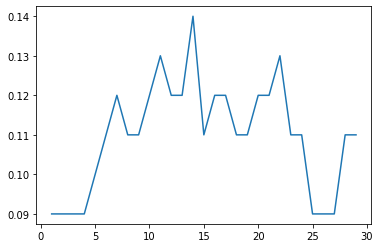

In [37]:
n_neighbours = []
scores = []

# Test out the results on different n (number of neighbors to consider)
for n in range(1,30):
    neigh.set_params(n_neighbors=n)
    predictions = neigh.predict(test_embeddings)

    metric = acc_metric.compute(predictions=predictions, references=test_labels)
    score = metric['accuracy']

    print('n:', n, 'acc:', score)

    n_neighbours.append(n)
    scores.append(score)


print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))

plt.plot(n_neighbours, scores)
plt.show()

### Fine-tuned with kNN (train=20k, test=100)
Gets a subset of the dataset and converts it to fine-tuned BERT embeddings

In [ ]:
train_num_examples = 20000
test_num_examples = 100

In [ ]:
train_examples = dataset['train'].select(range(train_num_examples))
test_examples = dataset['test'].select(range(test_num_examples))

test_embeddings, test_lables = get_embeddings(test_examples)
train_embeddings, train_labels = get_embeddings(train_examples)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fits kNN with the training embeddings. ``weights=distance`` will consider closer neighbors more important.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(weights="distance")
neigh.fit(train_embeddings, train_labels)

KNeighborsClassifier(weights='distance')

Here the notebook runs the predictions on different hyperparameters to see how it performs on different settings - which are then plotted

n: 1 acc: 0.08
n: 2 acc: 0.08
n: 3 acc: 0.08
n: 4 acc: 0.08
n: 5 acc: 0.07
n: 6 acc: 0.09
n: 7 acc: 0.1
n: 8 acc: 0.12
n: 9 acc: 0.12
n: 10 acc: 0.12
n: 11 acc: 0.13
n: 12 acc: 0.13
n: 13 acc: 0.13
n: 14 acc: 0.14
n: 15 acc: 0.13
n: 16 acc: 0.14
n: 17 acc: 0.14
n: 18 acc: 0.13
n: 19 acc: 0.11
n: 20 acc: 0.11
n: 21 acc: 0.11
n: 22 acc: 0.11
n: 23 acc: 0.12
n: 24 acc: 0.13
n: 25 acc: 0.14
n: 26 acc: 0.14
n: 27 acc: 0.14
n: 28 acc: 0.14
n: 29 acc: 0.14

Training examples: 20000
Test examples: 100


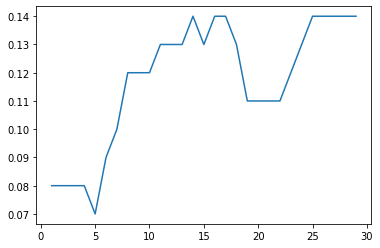

In [42]:
n_neighbours = []
scores = []

# Test out the results on different n (number of neighbors to consider)
for n in range(1,30):
    neigh.set_params(n_neighbors=n)
    predictions = neigh.predict(test_embeddings)

    metric = acc_metric.compute(predictions=predictions, references=test_labels)
    score = metric['accuracy']

    print('n:', n, 'acc:', score)

    n_neighbours.append(n)
    scores.append(score)


print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))

plt.plot(n_neighbours, scores)
plt.show()